In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import math

In [44]:
file_path = './dataset/'
file_name_A = 'cityA_groundtruthdata.csv.gz'
file_name_B = 'cityB_challengedata.csv.gz'
file_name_C = 'cityC_challengedata.csv.gz'
file_name_D = 'cityD_challengedata.csv.gz'

In [45]:
traj_A = pd.read_csv(file_path + file_name_A, compression='gzip').to_numpy()
traj_B = pd.read_csv(file_path + file_name_B, compression='gzip').to_numpy()
traj_C = pd.read_csv(file_path + file_name_C, compression='gzip').to_numpy()
traj_D = pd.read_csv(file_path + file_name_D, compression='gzip').to_numpy()

# Distance Statics

In [46]:
def Euclidean_Distance(point1, point2):
    """
    计算二维空间中两个点之间的欧式距离。
    
    参数:
    point1 (tuple): 第一个点的坐标，格式为 (x1, y1);
    point2 (tuple): 第二个点的坐标，格式为 (x2, y2)
    
    返回值:
    float: 两个点之间的欧式距离
    """
    x1, y1 = point1
    x2, y2 = point2
    distance = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    return distance

### Distance/User

In [47]:
def distant_per_user(traj):
    """
    计算每个用户的轨迹总距离：
    输入: numpy数组(uid, day, timeslot, x, y)
    返回: numpy数组(uid, distance)
    """
    dis_peruser = []
    uid, dis = -1, 0

    for row in traj:
        if uid != row[0]:
            if uid != -1:
                dis_peruser.append([uid, dis])
            uid = row[0]
            x, y = row[3], row[4]
            dis = 0
            continue
        dis += Euclidean_Distance((x,y),(row[3],row[4]))
        x, y = row[3], row[4]
    dis_peruser.append([uid, dis])

    return np.array(dis_peruser)

In [48]:
dis_pu_A = distant_per_user(traj_A)
dis_pu_B = distant_per_user(traj_B)
dis_pu_C = distant_per_user(traj_C)
dis_pu_D = distant_per_user(traj_D)

In [53]:
A = np.mean(dis_pu_A[:, 1])
B = np.mean(dis_pu_B[:, 1]) * 75 / 60
C = np.mean(dis_pu_C[:, 1]) * 75 / 60
D = np.mean(dis_pu_D[:, 1]) * 75 / 60

mean_dis_pp = [A, B, C, D]
mean_dis_pp

[6386.78283373992, 5977.300387516389, 4949.640611295292, 5438.762452423139]

In [83]:
def plot_distribution_dis_pu(dis_pu, city):
    """绘制平均轨迹距离用户数分布的柱状图，用户数及距离均归一化"""
    counts, bins = np.histogram(dis_pu[:,1], bins=100)
    total_dis = bins[-1]
    normalized_counts = counts / np.sum(counts)    # 归一化频数
    bins[:] = bins[:] / bins[-1]

    # 绘制频率归一化的柱状图
    plt.figure()
    plt.bar(bins[:-1], normalized_counts, width=np.diff(bins), edgecolor='black', alpha=0.7)

    # 添加图表标题和标签
    plt.title('Distribution of distance in 75days for ' + city)
    plt.xlabel('Distance(normalized, total=' + str(total_dis) + ')' )
    plt.ylabel('#users(normalized, total=' + str(len(dis_pu)) + ')')

    # 显示图表
    plt.show()

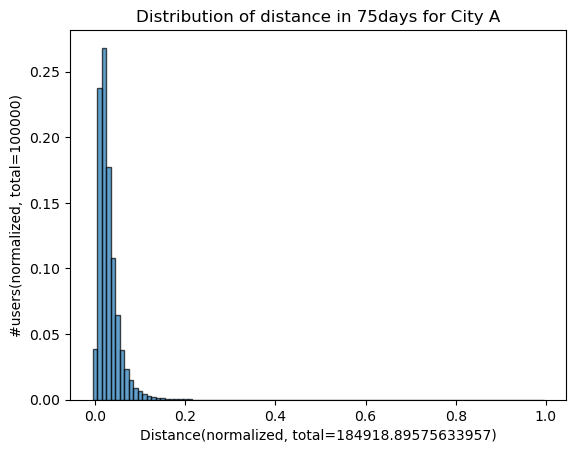

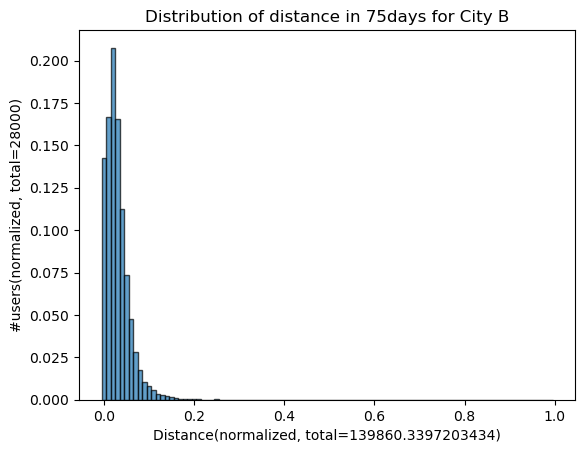

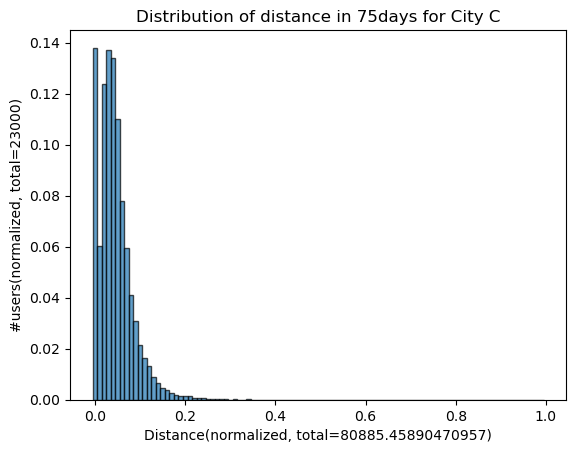

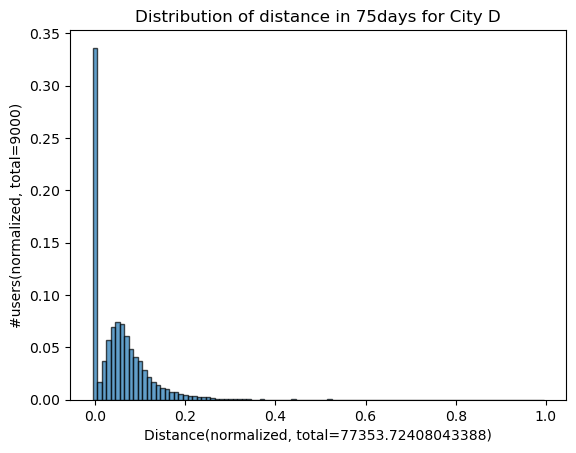

In [84]:
plot_distribution_dis_pu(dis_pu_A, 'City A')
plot_distribution_dis_pu(dis_pu_B, 'City B')
plot_distribution_dis_pu(dis_pu_C, 'City C')
plot_distribution_dis_pu(dis_pu_D, 'City D')

### Distance/(Day*User)

In [55]:
def distant_peruser_perday(traj): 
    """
    计算每个用户每天的轨迹总距离
    输入：numpy数组(uid, day, timeslot, x, y)
    输出：numpy数组(uid, day, distance)
    """
    dis_pp = []
    uid, day, dis = -1, -1, 0

    for row in traj:
        if (uid != row[0]) or (day != row[1]):
            if (uid != -1) and (day != -1):
                dis_pp.append([uid, day, dis])
            uid = row[0]
            day = row[1]
            x, y = row[3], row[4]
            dis = 0
            continue
        dis += Euclidean_Distance((x,y),(row[3],row[4]))
        x, y = row[3], row[4]
    dis_pp.append([uid, day, dis])

    return np.array(dis_pp)

In [56]:
dis_pp_A = distant_peruser_perday(traj_A)
dis_pp_B = distant_peruser_perday(traj_B)
dis_pp_C = distant_peruser_perday(traj_C)
dis_pp_D = distant_peruser_perday(traj_D)

In [57]:
A = np.mean(dis_pp_A[:, 2])
B = np.mean(dis_pp_B[:, 2])
C = np.mean(dis_pp_C[:, 2])
D = np.mean(dis_pp_D[:, 2])

mean_dis_pp = [A, B, C, D]
mean_dis_pp

[84.31122178253938, 72.40116875705662, 61.18924424382165, 88.62741117567222]

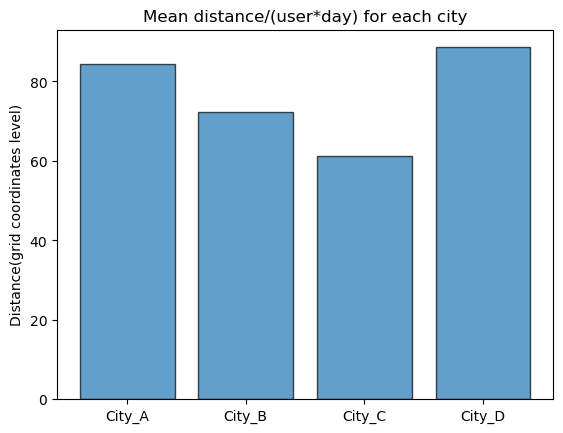

In [68]:
# 绘制柱状图
x_label = ['City_A', 'City_B', 'City_C', 'City_D']
plt.bar(x_label, mean_dis_pp, edgecolor='black', alpha=0.7)

# 添加图表标题和标签
plt.title('Mean distance/(user*day) for each city')
plt.ylabel('Distance(grid coordinates level)')

# 显示图表
plt.show()

In [88]:
def plot_distribution_dis_pp(dis_pp, city):
    """绘制每天平均轨迹距离用户数分布的柱状图，用户数及距离均归一化"""
    counts, bins = np.histogram(dis_pp[:,2], bins=100)
    total_dis = bins[-1]
    normalized_counts = counts / np.sum(counts)    # 归一化频数
    bins[:] = bins[:] / bins[-1]

    # 绘制频率归一化的柱状图
    plt.figure()
    plt.bar(bins[:-1], normalized_counts, width=np.diff(bins), edgecolor='black', alpha=0.7)

    # 添加图表标题和标签
    plt.title('Distribution of distance per day for ' + city)
    plt.xlabel('Distance(normalized, total=' + str(total_dis) + ')' )
    plt.ylabel('#users(normalized, total=' + str(len(dis_pp)) + ')')

    # 显示图表
    plt.show()

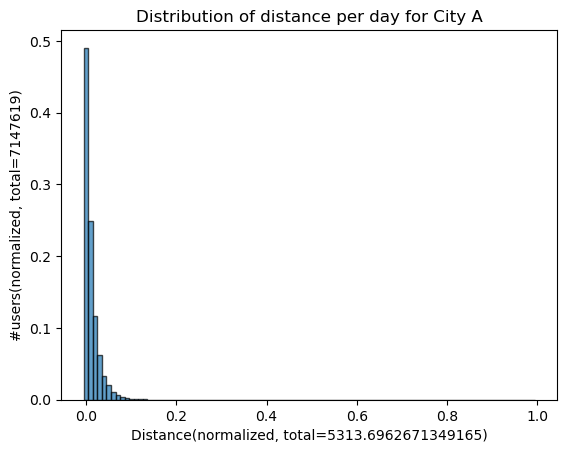

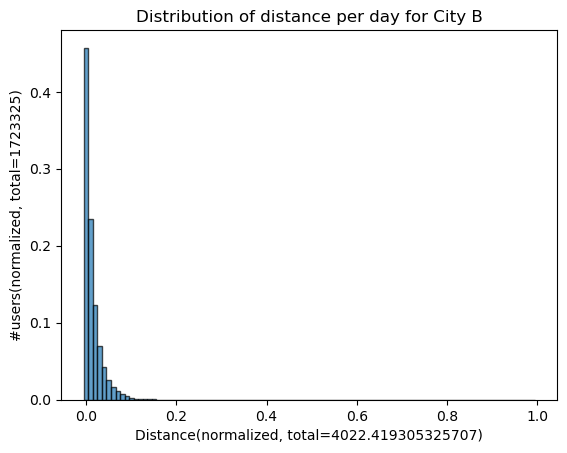

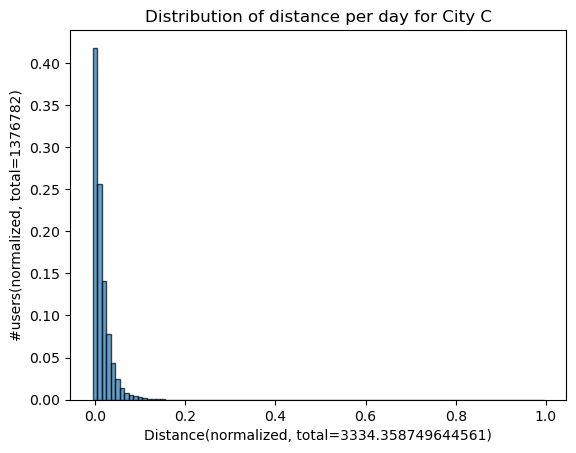

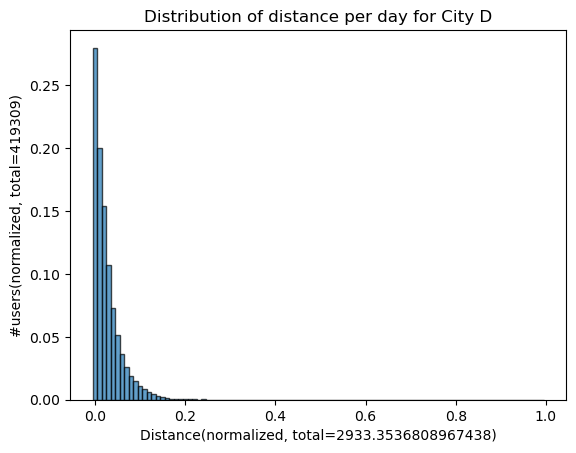

In [90]:
plot_distribution_dis_pp(dis_pp_A, 'City A')
plot_distribution_dis_pp(dis_pp_B, 'City B')
plot_distribution_dis_pp(dis_pp_C, 'City C')
plot_distribution_dis_pp(dis_pp_D, 'City D')

# Temporal Statics

## User Activity Time Distribution

In [91]:
traj_A[:200]

array([[  0,   0,   1,  79,  86],
       [  0,   0,   2,  79,  86],
       [  0,   0,   8,  77,  86],
       [  0,   0,   9,  77,  86],
       [  0,   0,  19,  81,  89],
       [  0,   0,  20,  82,  88],
       [  0,   0,  21,  81,  89],
       [  0,   0,  22,  81,  89],
       [  0,   0,  24,  76,  86],
       [  0,   0,  25,  75,  82],
       [  0,   0,  27,  76,  84],
       [  0,   0,  29,  76,  83],
       [  0,   0,  30,  77,  86],
       [  0,   0,  42,  79, 106],
       [  0,   0,  43,  76,  85],
       [  0,   0,  45,  77,  86],
       [  0,   1,  17,  76,  84],
       [  0,   1,  18,  76,  84],
       [  0,   1,  19,  76,  85],
       [  0,   1,  20,  75,  85],
       [  0,   1,  21,  77,  86],
       [  0,   1,  22,  80,  83],
       [  0,   1,  23,  77,  85],
       [  0,   1,  24,  77,  86],
       [  0,   1,  40,  78,  85],
       [  0,   1,  43,  77,  85],
       [  0,   2,  12,  84,  89],
       [  0,   2,  13,  89,  78],
       [  0,   2,  14, 115,  80],
       [  0,  

In [ ]:
def activity_time_histogram(traj):


# Spactial Statics